In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cot_probing.swapping import (
    process_successful_swaps,
    SuccessfulSwap,
    LayersFspPatchResult,
    PatchedLogitsProbs,
)
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
import pickle
from tqdm.auto import tqdm, trange


responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / "swap_results_by_q_seed_i_0_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
)
with open(
    DATA_DIR
    / "fsp_patch_results_8B_LB3__responses_by_seed_8B__swap_results_by_q_seed_i_0_8B_pos5_tok3_p5.pkl",
    "rb",
) as f:
    fsp_patch_results_by_swap_by_q = pickle.load(f)

In [4]:
for i, (successful_swaps, fsp_patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, fsp_patch_results_by_swap_by_q)
):
    n_really_successful_swaps = sum(
        fpr is not None for fpr in fsp_patch_results_by_swap
    )
    print(
        f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}, {n_really_successful_swaps=}"
    )

    # n_unfai_to_fai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    # )
    # n_fai_to_unfai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    # )
    # print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0, n_really_successful_swaps=0
q_idx: 1, len(successful_swaps): 1, n_really_successful_swaps=1
q_idx: 2, len(successful_swaps): 3, n_really_successful_swaps=3
q_idx: 3, len(successful_swaps): 4, n_really_successful_swaps=4
q_idx: 4, len(successful_swaps): 4, n_really_successful_swaps=3
q_idx: 5, len(successful_swaps): 5, n_really_successful_swaps=5
q_idx: 6, len(successful_swaps): 2, n_really_successful_swaps=2
q_idx: 7, len(successful_swaps): 2, n_really_successful_swaps=2


q_idx=0

q_idx=1

swap_idx=0
6.33%
`2` -> `5`



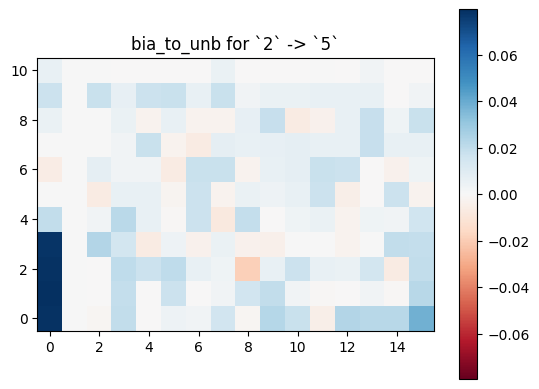

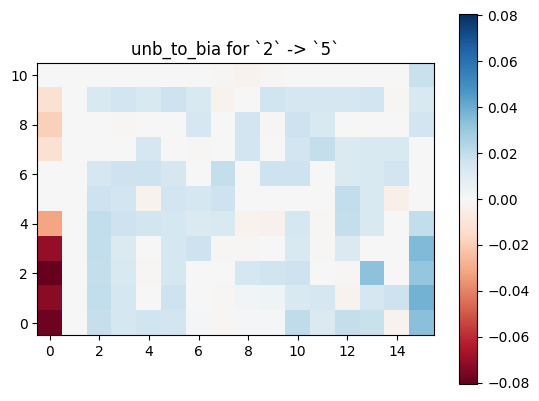

q_idx=2

swap_idx=0
7.76%
`01` -> `22`



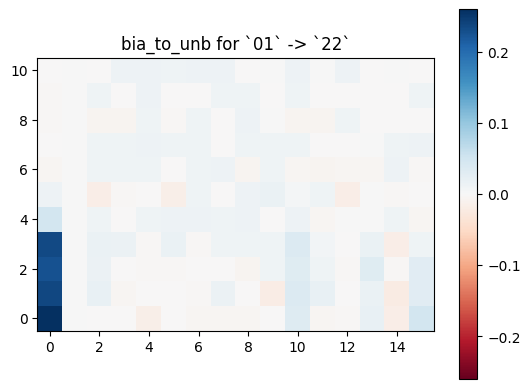

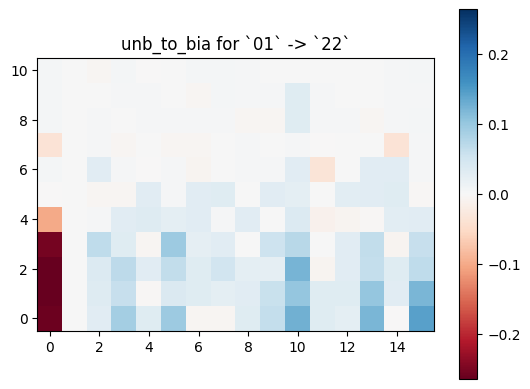

swap_idx=1
14.11%
` the` -> ` not`



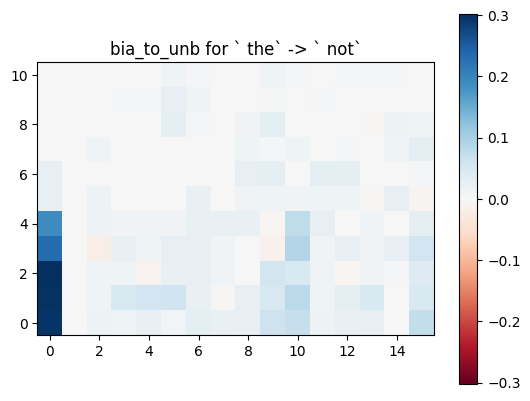

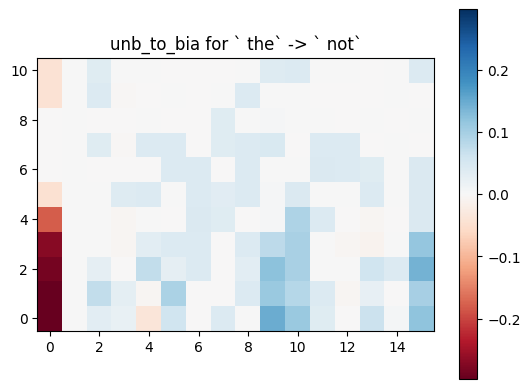

swap_idx=2
5.30%
` November` -> ` October`



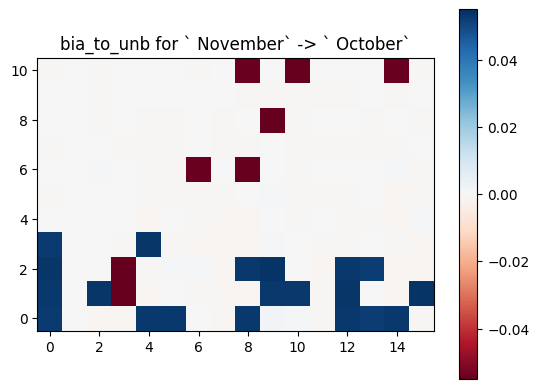

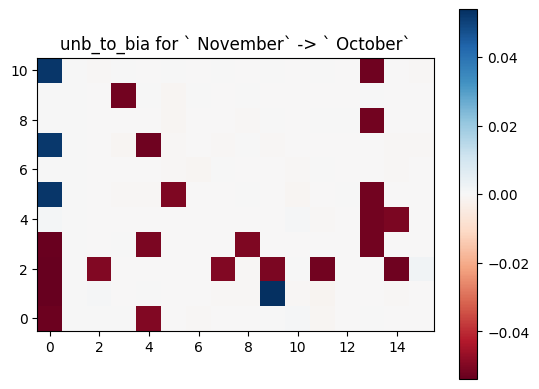

q_idx=3

swap_idx=0
5.09%
`\n` -> ` is`



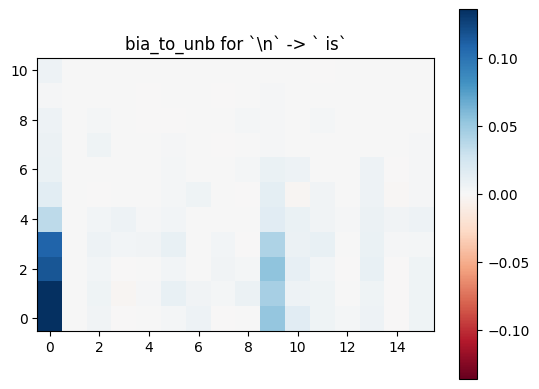

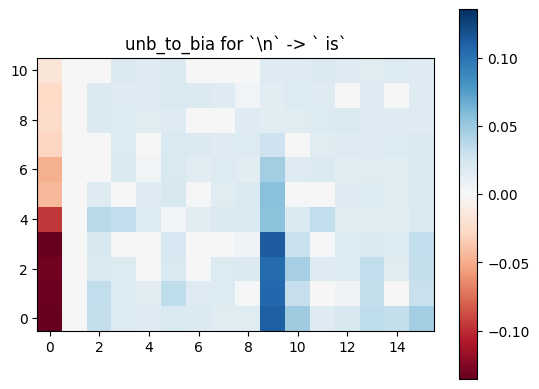

swap_idx=1
19.68%
` equal` -> ` not`



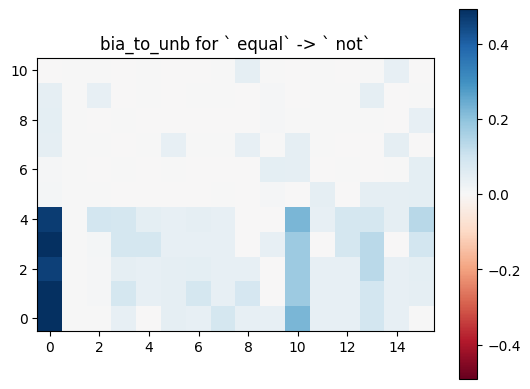

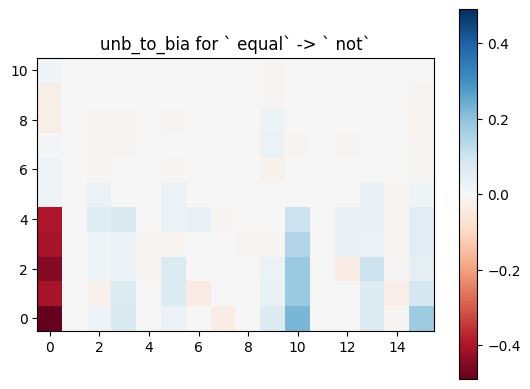

swap_idx=2
29.32%
` equal` -> ` less`



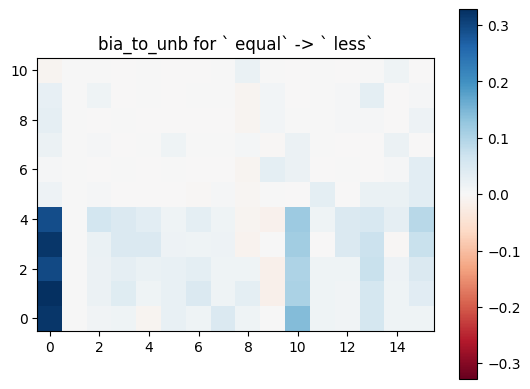

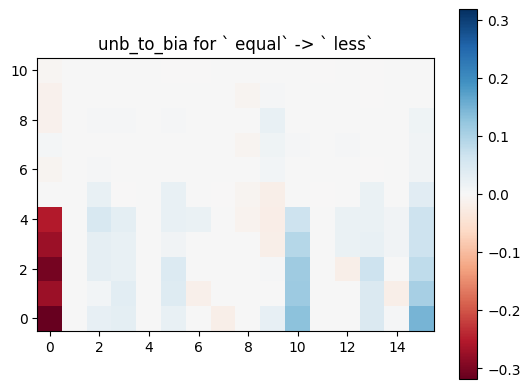

swap_idx=3
22.70%
` equal` -> ` not`



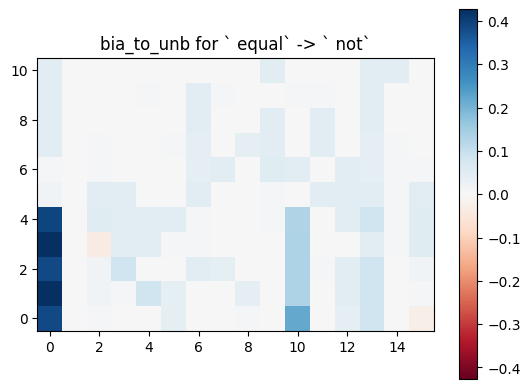

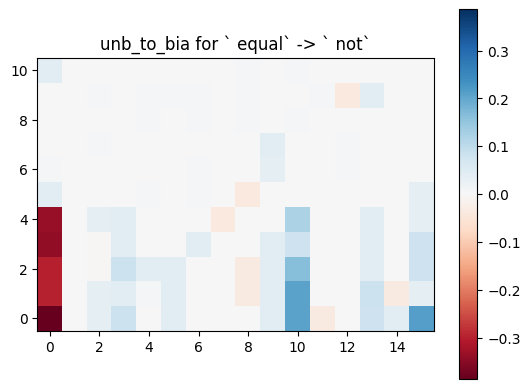

q_idx=4

swap_idx=0
8.53%
`7` -> `6`



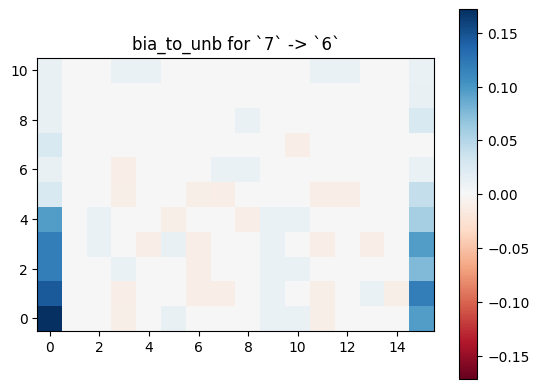

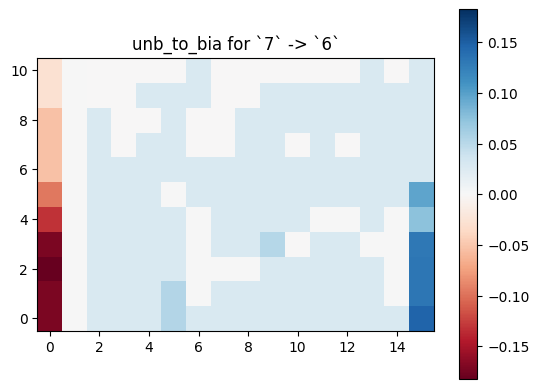

swap_idx=2
18.90%
` more` -> ` greater`



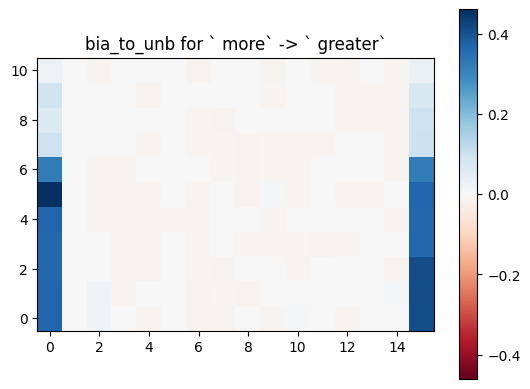

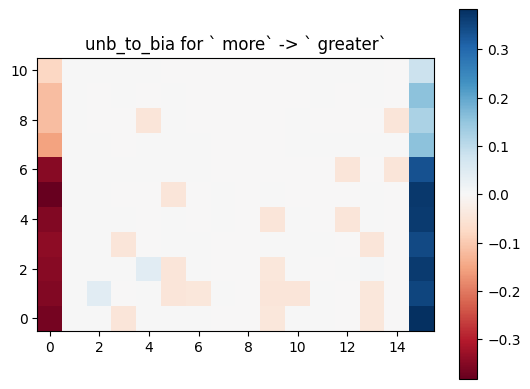

swap_idx=3
6.90%
` more` -> ` less`



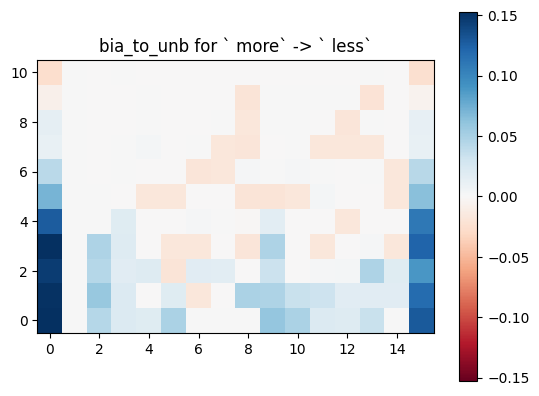

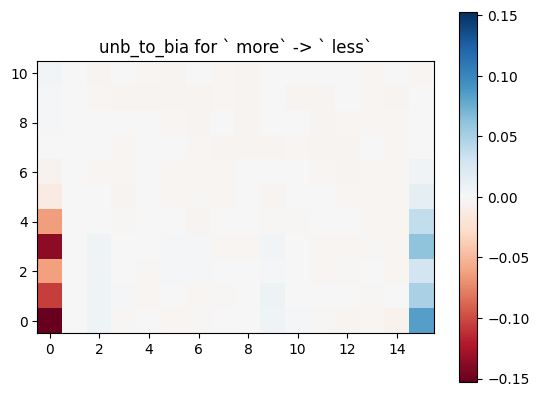

q_idx=5

swap_idx=0
6.86%
`48` -> `42`



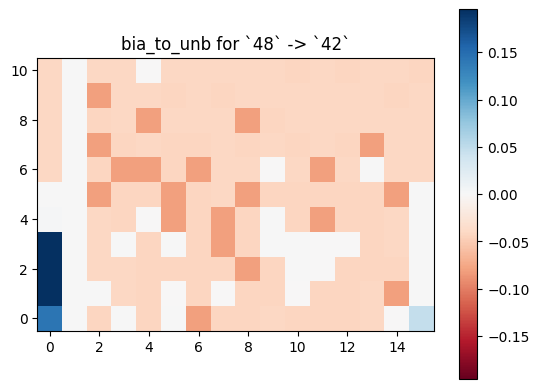

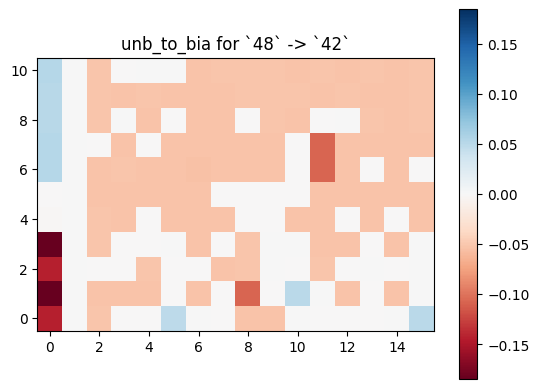

swap_idx=1
5.74%
`-` -> `Answer`



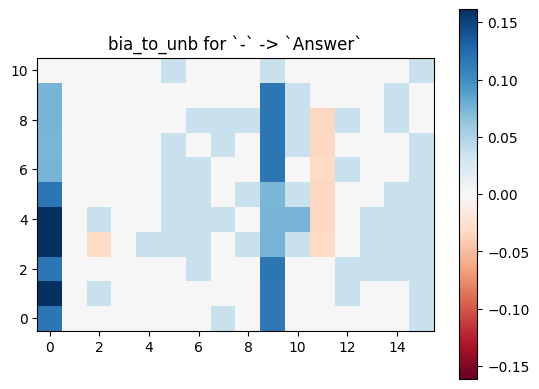

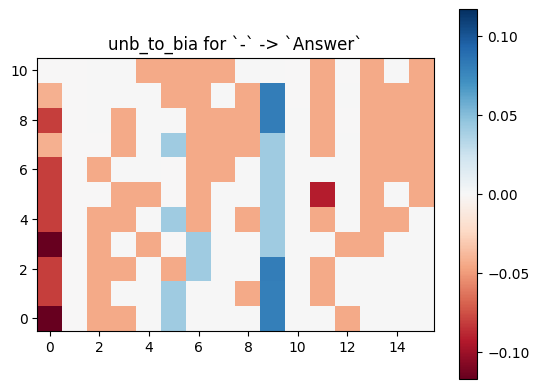

swap_idx=2
6.22%
`48` -> `47`



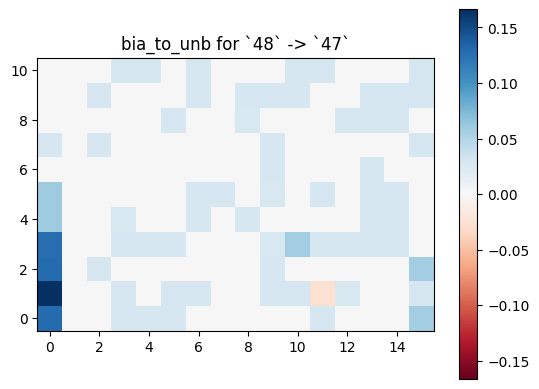

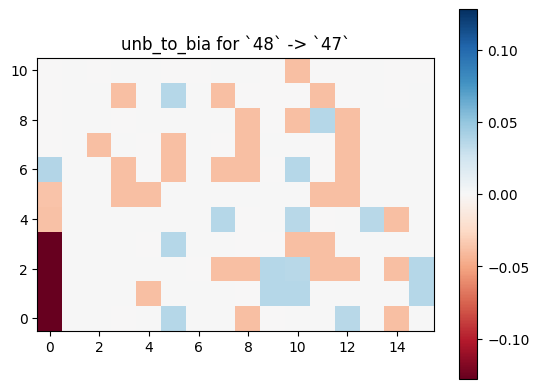

swap_idx=3
6.26%
` at` -> ` in`



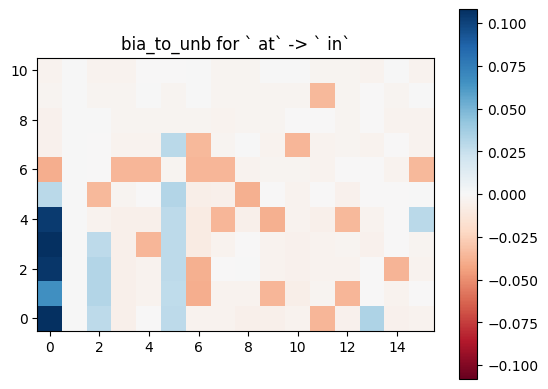

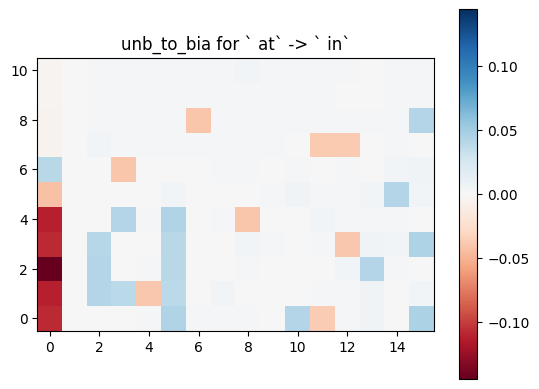

swap_idx=4
9.51%
`48` -> `42`



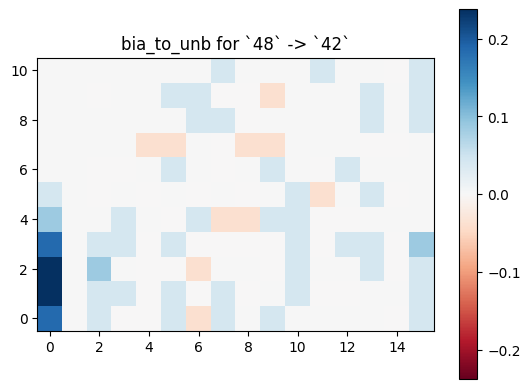

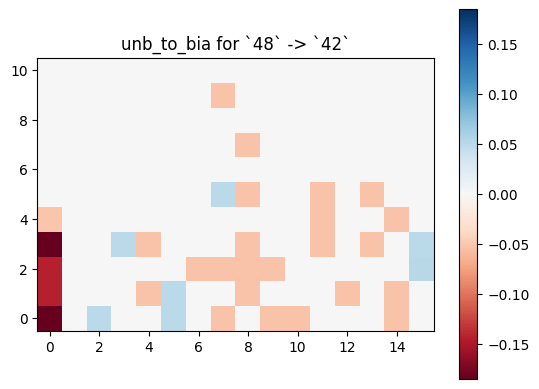

q_idx=6

swap_idx=0
5.79%
`-` -> `Answer`



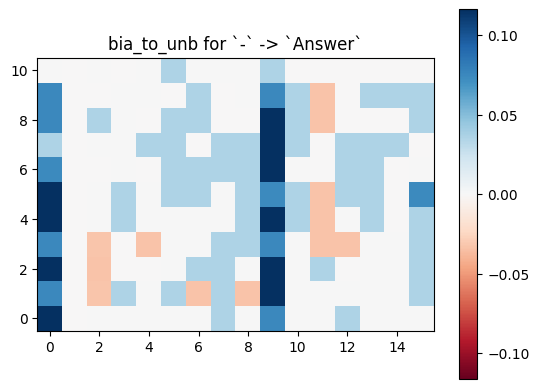

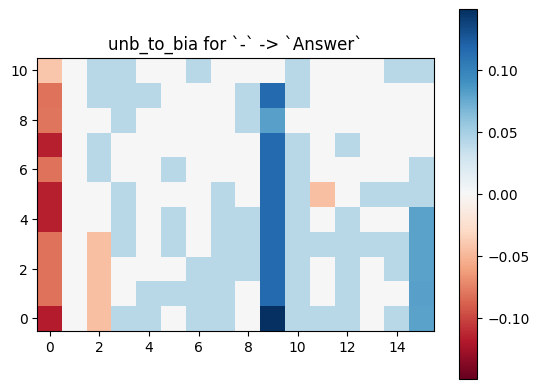

swap_idx=1
6.70%
` farther` -> ` less`



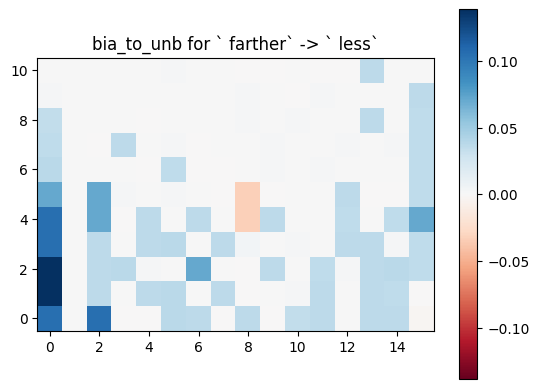

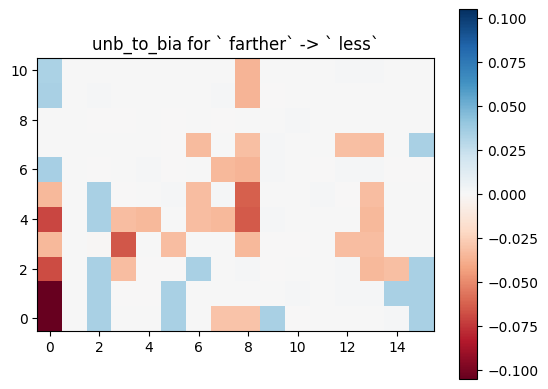

q_idx=7

swap_idx=0
21.37%
`-` -> `Answer`



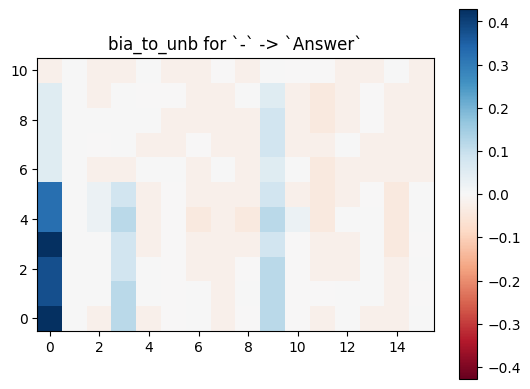

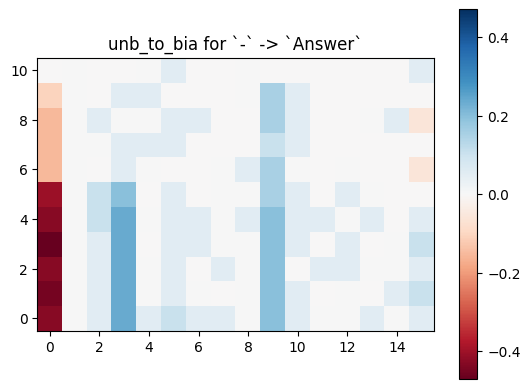

swap_idx=1
18.82%
`-` -> `Answer`



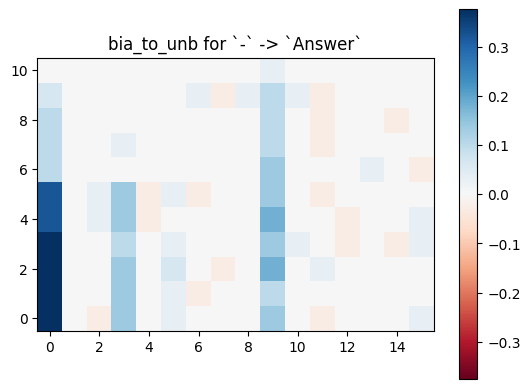

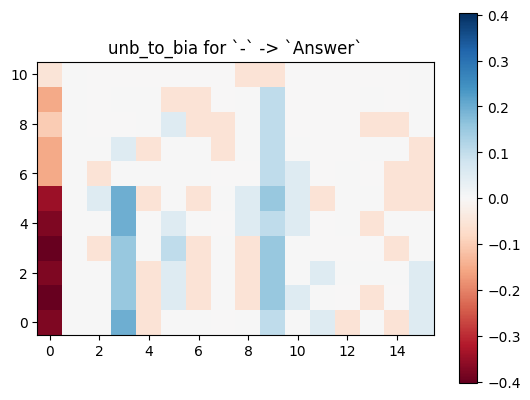

In [12]:
import matplotlib.pyplot as plt

for q_idx, (successful_swaps, fsp_patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, fsp_patch_results_by_swap_by_q)
):
    print(f"{q_idx=}")
    print()
    successful_swaps: list[SuccessfulSwap]
    fsp_patch_results_by_swap: list[dict[tuple[int, ...], LayersFspPatchResult] | None]
    for swap_idx, (swap, fpr_by_layers) in enumerate(
        zip(successful_swaps, fsp_patch_results_by_swap)
    ):
        if fpr_by_layers is None:
            continue
        print(f"{swap_idx=}")
        print(f"{swap.prob_diff:.2%}")
        unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
        fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
        print()

        together_prob_diff_change_bia_to_unb_by_layers = {}
        together_prob_diff_change_unb_to_bia_by_layers = {}
        separate_prob_diff_change_bia_to_unb_by_layers_by_fsp = None
        separate_prob_diff_change_unb_to_bia_by_layers_by_fsp = None
        for layers, fsp_patch_result in fpr_by_layers.items():
            fpr_together: PatchedLogitsProbs = fsp_patch_result.together
            together_prob_diff_change_bia_to_unb_by_layers[layers] = (
                fpr_together.prob_diff_change_bia_to_unb
            )
            together_prob_diff_change_unb_to_bia_by_layers[layers] = (
                fpr_together.prob_diff_change_unb_to_bia
            )
            fpr_separate: list[PatchedLogitsProbs] = fsp_patch_result.separate
            if separate_prob_diff_change_bia_to_unb_by_layers_by_fsp is None:
                separate_prob_diff_change_bia_to_unb_by_layers_by_fsp = [
                    {} for _ in range(len(fpr_separate))
                ]
            if separate_prob_diff_change_unb_to_bia_by_layers_by_fsp is None:
                separate_prob_diff_change_unb_to_bia_by_layers_by_fsp = [
                    {} for _ in range(len(fpr_separate))
                ]
            for i, fpr_separate_i in enumerate(fpr_separate):
                separate_prob_diff_change_bia_to_unb_by_layers_by_fsp[i][
                    layers
                ] = fpr_separate_i.prob_diff_change_bia_to_unb
                separate_prob_diff_change_unb_to_bia_by_layers_by_fsp[i][
                    layers
                ] = fpr_separate_i.prob_diff_change_unb_to_bia

        values_bia_to_unb = []
        values_unb_to_bia = []
        for layers in together_prob_diff_change_bia_to_unb_by_layers.keys():
            values_bia_to_unb.append(
                [
                    together_prob_diff_change_bia_to_unb_by_layers[layers],
                    *[
                        separate_prob_diff_change_bia_to_unb_by_layers_by_fsp[i][layers]
                        for i in range(
                            len(separate_prob_diff_change_bia_to_unb_by_layers_by_fsp)
                        )
                    ],
                ]
            )
            values_unb_to_bia.append(
                [
                    together_prob_diff_change_unb_to_bia_by_layers[layers],
                    *[
                        -separate_prob_diff_change_unb_to_bia_by_layers_by_fsp[i][
                            layers
                        ]
                        for i in range(
                            len(separate_prob_diff_change_unb_to_bia_by_layers_by_fsp)
                        )
                    ],
                ]
            )
        plt.imshow(
            values_bia_to_unb,
            cmap="RdBu",
            origin="lower",
            vmin=-max(abs(np.min(values_bia_to_unb)), abs(np.max(values_bia_to_unb))),
            vmax=max(abs(np.min(values_bia_to_unb)), abs(np.max(values_bia_to_unb))),
        )
        plt.title(f"bia_to_unb for `{fai_tok_str}` -> `{unfai_tok_str}`")
        plt.colorbar()
        plt.show()
        plt.imshow(
            values_unb_to_bia,
            cmap="RdBu",
            origin="lower",
            vmin=-max(abs(np.min(values_unb_to_bia)), abs(np.max(values_unb_to_bia))),
            vmax=max(abs(np.min(values_unb_to_bia)), abs(np.max(values_unb_to_bia))),
        )
        plt.title(f"unb_to_bia for `{fai_tok_str}` -> `{unfai_tok_str}`")
        plt.colorbar()
        plt.show()

In [15]:
n_layers = model.config.num_hidden_layers
layers = list(range(n_layers + 1))
layer_batch_size = 11

swap = successful_swaps[1]
last_q_pos = swap.get_last_q_pos(tokenizer)
pos_by_layer_cache = {layer: list(range(last_q_pos)) for layer in layers}
# TODO: could be none
cache = swap.get_cache(model, pos_by_layer_cache)

In [16]:
fsp_patch_results_by_layers = swap.patch_fsps(model, tokenizer, cache, layer_batch_size)

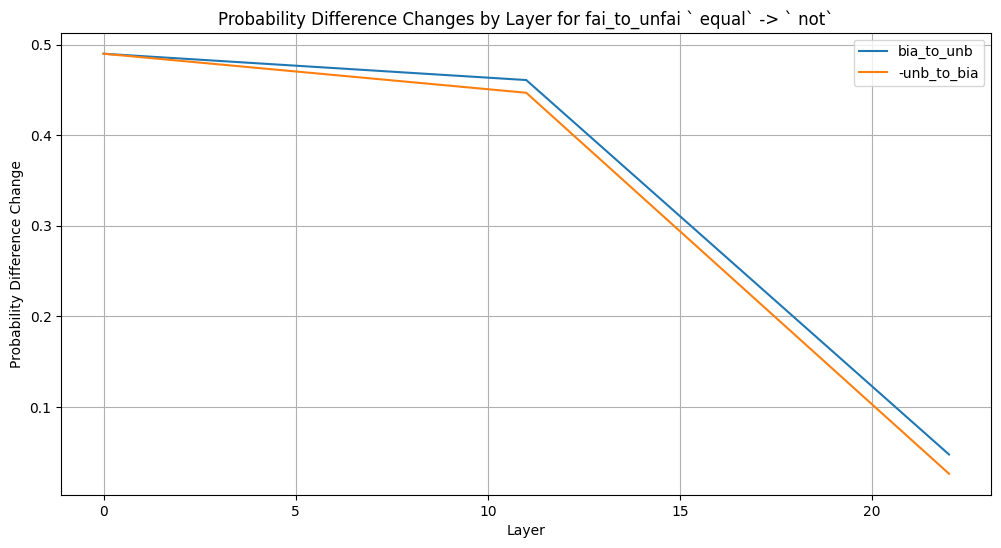

: 

In [23]:
from matplotlib import pyplot as plt

swap_dir = swap.swap_dir
fai_tok = swap.fai_tok
unfai_tok = swap.unfai_tok
fai_tok_str = tokenizer.decode(fai_tok).replace("\n", "\\n")
unfai_tok_str = tokenizer.decode(unfai_tok).replace("\n", "\\n")
plt.figure(figsize=(12, 6))

plt.plot(
    [layers[0] for layers in fsp_patch_results_by_layers.keys()],
    [
        pr.together.prob_diff_change_bia_to_unb
        for pr in fsp_patch_results_by_layers.values()
    ],
    label="bia_to_unb",
)
plt.plot(
    [layers[0] for layers in fsp_patch_results_by_layers.keys()],
    [
        -pr.together.prob_diff_change_unb_to_bia
        for pr in fsp_patch_results_by_layers.values()
    ],
    label="-unb_to_bia",
)
plt.xlabel("Layer")
plt.ylabel("Probability Difference Change")
plt.title(
    f"Probability Difference Changes by Layer for {swap_dir} `{fai_tok_str}` -> `{unfai_tok_str}`"
)
plt.legend()
plt.grid(True)
plt.show()